In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import os
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

import quantnn as q
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from load_data import ConvertDatasetToNumpy, ComputeStatsFromNumpyFiles, GOESRETRIEVALSDataset, ToTensor, Standardize


In [2]:
class QuantileLoss:
    def __init__(self, quantiles):
        self.quantiles = quantiles
        
    def __call__(self, y_pred, y_true):
        return q.quantile_loss(y_pred, self.quantiles, y_true).mean()
        
        
class Net(nn.Module):
    def __init__(self, num_quantiles, num_channels, kernel_size):
        super(Net, self).__init__()
    
        self.c1 = nn.Conv2d(num_channels, 128, kernel_size)
        self.c2 = nn.Conv2d(128, 128, kernel_size)
        self.c3 = nn.Conv2d(128, num_quantiles, kernel_size)
        self.b = nn.BatchNorm2d(128)
    
    
    def forward(self, x):

        x = F.relu(self.b(self.c1(x)))
        
        for i in range(2):
            x = F.relu(self.b(self.c2(x)))
        
        x = self.c3(x)
        
        return x
        

def train(model, X, y, m, optimizer, criterion):
    model.zero_grad()
    output = model(X)

    fillval = 0
    m_rep = m.unsqueeze(1).repeat(1,output.shape[1], 1, 1)
    output[torch.where(m_rep==0)] = fillval
    y[torch.where(m==0)] = fillval

    loss = criterion(output, y)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
    loss.backward()
    optimizer.step()

    return loss

def plotRandomSample(train_dataset):
    X_train = [train_dataset[i]['box'] for i in range(len(train_dataset))]
    y_train = [train_dataset[i]['label'] for i in range(len(train_dataset))]

    from matplotlib.colors import LogNorm
    from matplotlib.gridspec import GridSpec

    f = plt.figure(figsize=(15, 6))
    gs =  GridSpec(2, 3, figure=f, height_ratios=[1.0, 0.1])
    index = np.random.randint(len(X_train))

    precip_norm = LogNorm(1e-2, 1e2)

    ax = plt.subplot(gs[0, 0])
    m = ax.imshow(X_train[index].numpy()[0])
    ax.grid(False)
    ax.set_title("(a) channel 8", loc="left")
    ax = plt.subplot(gs[1, 0])
    plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

    ax = plt.subplot(gs[0, 1])
    m = ax.imshow(X_train[index].numpy()[1])
    ax.grid(False)
    ax.set_title("(b) channel 13", loc="left")
    ax = plt.subplot(gs[1, 1])
    plt.colorbar(m, cax=ax, orientation="horizontal", label="Normalized brightness temperature")

    ax = plt.subplot(gs[0, 2])
    m = ax.imshow(y_train[index].numpy(), norm=precip_norm)
    ax.grid(False)
    ax.set_title("(c) Reference rain rate", loc="left")
    ax = plt.subplot(gs[1, 2])
    plt.colorbar(m, cax=ax, orientation="horizontal", label=r"Rain rate [mm/h]")

    plt.tight_layout()
    

In [3]:

channels = [8,13]

EPOCHS = 5
BATCH_SIZE = 2

quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]
#quantiles = [0.01, 0.5, 0.99]

path_to_load_train_data = 'data/first_net_dataset/train/'
path_to_save_train_data = 'data/first_net_dataset/train/npy_files'
path_to_stats = os.path.join(Path(path_to_save_train_data).parent, Path('stats.npy'))

ConvertDatasetToNumpy(path_to_load_data = path_to_load_train_data,
                      path_to_save_data = path_to_save_train_data)

train_dataset = GOESRETRIEVALSDataset(
    path_to_data = path_to_save_train_data,
    channels = channels, 
    transform = transforms.Compose([Standardize(path_to_save_train_data, path_to_stats, channels), ToTensor()]),
    singles = False
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

[[233.22173112 269.27052031]
 [  7.07067325  20.06164785]]


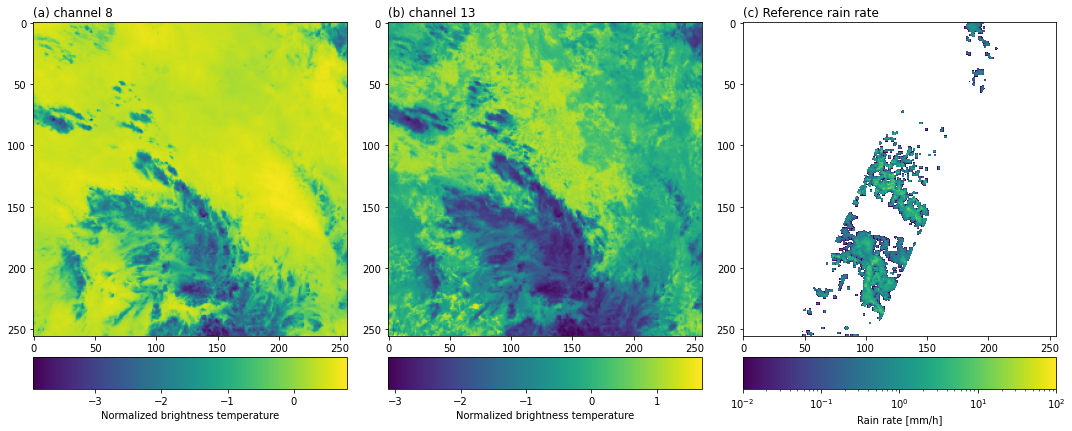

In [4]:
plotRandomSample(train_dataset)

In [5]:
net = Net(len(quantiles), len(channels), 1)

criterion = QuantileLoss(quantiles)
optimizer = SGD(net.parameters(), lr = 0.1)


for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_index, batch in enumerate(train_dataloader):
        X = batch['box']
        y = batch['label']
        m = batch['mask']

        batch_loss = train(net, X, y, m, optimizer, criterion)
        print(batch_loss.item())
        epoch_loss += batch_loss.item()
        
    print(epoch, epoch_loss, 'average: ', epoch_loss/(batch_index+1))


/home/ingrid/anaconda3/envs/geostat/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0.046916522085666656
0.024216799065470695
0.04719449579715729
0.07281459122896194
0.05062312260270119
0.05414009839296341
0.04115211218595505
0.08859752863645554
0.031247982755303383
0.029177434742450714
0.03753560036420822
0.07207409292459488
0.024995913729071617
0.01798255182802677
0.0315176397562027
0.0160150695592165
0.050235189497470856
0.012018238194286823
0.014399966225028038
0.03616968169808388
0.04432656988501549
0.030084775760769844
0.016799641773104668
0.052961885929107666
0.01762220449745655
0.020390896126627922
0.03257408365607262
0.02938508614897728
0.046736691147089005
0.04448525607585907
0.03033565543591976
0.0588858500123024
0.04167908802628517
0.016789020970463753
0.016181698068976402
0.011696682311594486
0.044034384191036224
0.026552610099315643
0.01967492513358593
0.02229025587439537
0.027980901300907135
0.016236577183008194
0.03571537509560585
0.024335680529475212
0.022817065939307213
0.023313205689191818
0.012659654952585697
0.009485648944973946
0.0320549048483371

0.03052694723010063
0.010829384438693523
0.05815517157316208
0.024954309687018394
0.049329061061143875
0.018647857010364532
0.016341302543878555
0.021228721365332603
0.013969034887850285
0.029635118320584297
0.01660647615790367
0.02245996706187725
0.015936538577079773
0.02401168830692768
0.005709302611649036
0.017426244914531708
0.014654697850346565
0.04819455370306969
0.010842557065188885
0.02302468568086624
0.01264413632452488
0.02912805788218975
0.005096490029245615
0.02404450997710228
0.004872563295066357
0.01282469928264618
0.011301466263830662
0.06931722164154053
0.031172730028629303
0.02977151609957218
0.003166574751958251
0.016004744917154312
0.019850173965096474
0.034441959112882614
0.03460938483476639
0.03178447112441063
0.012617732398211956
0.027149878442287445
0.010655194520950317
0.09090311080217361
0.01839294098317623
0.028712032362818718
0.024092931300401688
0.02068157307803631
0.0082677211612463
0.04308019205927849
0.005072508938610554
0.01519025955349207
0.005679076537

0.016484038904309273
0.009379055351018906
0.03241606056690216
0.011317857541143894
0.04727550223469734
0.005557609722018242
0.018186938017606735
0.02405099757015705
0.03427213430404663
0.03188908472657204
0.0034461738541722298
0.016394132748246193
0.010886901058256626
0.0044265855103731155
0.04419924318790436
0.03373722732067108
0.037845268845558167
0.01004655472934246
0.004223401192575693
0.03375544399023056
0.029701678082346916
0.009654565714299679
0.014864428900182247
0.023198595270514488
0.02087021805346012
0.010900919325649738
0.04395691305398941
0.01394334901124239
0.03925611078739166
0.0058942087925970554
0.09054267406463623
0.00651157833635807
0.019029121845960617
0.01879715546965599
0.029163576662540436
0.00393766351044178
0.006551114376634359
0.011967867612838745
0.028133176267147064
0.043657027184963226
0.035153649747371674
0.027814220637083054
0.037823788821697235
4 3.79004022362642 average:  0.022831567612207348


In [6]:
path_to_load_test_data = 'data/first_net_dataset/test/'
path_to_save_test_data = 'data/first_net_dataset/test/npy_files'

ConvertDatasetToNumpy(path_to_load_data = path_to_load_test_data,
                      path_to_save_data = path_to_save_test_data)

test_dataset = GOESRETRIEVALSDataset(
    path_to_data = path_to_save_test_data,
    channels = channels, 
    transform = transforms.Compose([Standardize(path_to_save_test_data, path_to_stats, channels), ToTensor()]),
    singles = False
)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

[[233.22173112 269.27052031]
 [  7.07067325  20.06164785]]


In [7]:
tot_loss = 0
for batch_index, batch in enumerate(test_dataloader):

    X = batch['box']
    y = batch['label']
    output = net(X)
    batch_loss = criterion(output, y)

    tot_loss += batch_loss.item()

print(tot_loss, tot_loss, 'average: ', tot_loss/batch_index)


40.13328891992569 40.13328891992569 average:  0.40538675676692615


(1, 13, 256, 256)
(1, 256, 256)
6


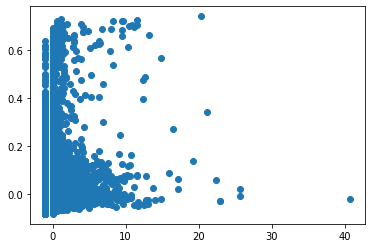

In [8]:

outp = output.detach().numpy()
print(outp.shape)
yp = y.detach().numpy()
print(yp.shape)


i = int(outp.shape[1]/2)
print(i)
plt.scatter(yp, outp[:,i])
plt.show()

In [ ]:
print(output)